In [1]:
import numpy as np
import sys
import cv2
from matplotlib import pyplot as plt
import glob
import math
import random

In [2]:
# def mouse_drawing(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print("Left click")
#         points.append((x, y))

# # cap = cv2.VideoCapture(0)
# cv2.namedWindow("Frame", cv2.WINDOW_NORMAL)
# cv2.setMouseCallback("Frame", mouse_drawing)
# points = []
# frame = cv2.imread('data/calib-object.jpg', cv2.IMREAD_COLOR)

# while True:
#     # _, frame = cap.read()
#     for center_position in points:
#         cv2.circle(frame, center_position, 15, (0, 0, 255), -1)
#     cv2.imshow("Frame", frame)
#     key = cv2.waitKey(1)
#     if key == ord('d'):
#         break
    
# # cap.release()
# cv2.destroyAllWindows()
# print(len(points))
# print(points)
# np.save("Points2.npy", np.array(points))

In [72]:
d = 28 
points3d = np.zeros((24,3))
for i in range(1,8):
    points3d[i,0] = i*d
for i in range(1,10):
    points3d[7+i,1] = i*d
for i in range(1,8):
    points3d[16+i,2] = i*d
points3d
np.save("Points3.npy", np.array(points3d))

In [73]:
points_2d = np.load("Points2.npy")
points_3d = np.load("Points3.npy")
points_3d_2 = points_3d*100

In [74]:
def norm_2d(data):
    s2 = math.sqrt(2)
    x = np.mean(data,axis=0)
    d = 0
    le = data.shape
    mat_nor = []
    for i in range(le[0]):
        t = (data[i][0]-x[0])**2 + (data[i][1]-x[1])**2
        d+=math.sqrt(t)
    d/=le[0]
    data1 = np.concatenate((data,np.ones((data.shape[0],1))),axis=1)
    t1 = s2/d
    t2 = -s2*x[0]/d
    t3 = -s2*x[1]/d
    mat_nor = [[t1,0,t2],[0,t1,t3],[0,0,1]]
    mat_nor=np.array(mat_nor)
    data_n = np.dot(mat_nor,data1.T)
    data_n = np.column_stack((data_n.T[:,0],data_n.T[:,1]))
    return data_n,mat_nor
points_2d_N,mat_nor2 = norm_2d(points_2d) 

In [75]:
def norm_3d(data):
    s3 = math.sqrt(3)
    x = np.mean(data,axis=0)
    d = 0
    le = data.shape
    mat_nor = []
    for i in range(le[0]):
        t = (data[i][0]-x[0])**2 + (data[i][1]-x[1])**2 + (data[i][2]-x[2])**2
        d+=math.sqrt(t)
    d/=le[0]
    data1 = np.concatenate((data,np.ones((data.shape[0],1))),axis=1)
    t1 = s3/d
    t2 = -s3*x[0]/d
    t3 = -s3*x[1]/d
    t4 = -s3*x[2]/d
    mat_nor = [[t1,0,0,t2],[0,t1,0,t3],[0,0,t1,t4],[0,0,0,1]]
    mat_nor=np.array(mat_nor)
    data_n1 = np.dot(mat_nor,data1.T)
    data_n = np.column_stack((data_n1.T[:,0],data_n1.T[:,1]))
    data_n = np.column_stack((data_n,data_n1.T[:,2]))
    return data_n,mat_nor
    

# Direct Linear Transform


In [76]:
def DLT(points_2d,points_3d,total_2dpoints,total_3dpoints,ret=False):
    #a = np.arange(21)
    #np.random.shuffle(a)
    # rand = a[:6]
    # sampled_points_3d = points_3d[rand]
    # sampled_points_2d = points_2d[rand]
    M = np.zeros((2*points_2d.shape[0],12))
    for i in range(points_2d.shape[0]):
        X,Y,Z = points_3d[i,:]
        u,v = points_2d[i,:]
        M[2*i,:] =   [0,0,0,0,-X,-Y,-Z,-1,v*X,v*Y,v*Z,v]
        M[2*i+1,:] = [-X,-Y,-Z,-1,0,0,0,0,u*X,u*Y,u*Z,u]
    #print(M)
    u,s,vh = np.linalg.svd(M)
    ind = np.argmin(s)
#     print(ind)
    Pt = vh[ind,:]
    P = Pt.reshape(3,4)
    #print("Projection Matrix")
    #print()
   # print(P)
    #print()
    # Calculate K,R,T
    hom = P[:,0:3]
    pt = P[:,3]
    hom_inv = np.linalg.inv(hom)
    t = - hom_inv.dot(pt)
    R,K = np.linalg.qr(hom_inv)
    R = R.T
    K = np.linalg.inv(K)
    K = K/K[2,2]
#     print("Camera Matrix")
#     print(K)
#     print()
#     print("Rotation Matrix")
#     print(R)
#     print()
#     print("Projection Center")
#     print(t)
    total_3dpoints = np.concatenate((total_3dpoints,np.ones((total_3dpoints.shape[0],1))),axis=1)
    pred_2d = P.dot(total_3dpoints.T).T
    for i in range(pred_2d.shape[0]):
        pred_2d[i,:] = pred_2d[i,:]/pred_2d[i,2]
    err = np.mean((total_2dpoints - pred_2d[:,:2])**2)
    #print(err)    
    return err,P,K,R,t

In [77]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(" "*25 + color.BOLD +" Scale = 28*28" + color.END+ "\n" )

print("="*25 + "  Original data input and Reconstruction  " + "="*25 + "\n")
err,P,K,R,t = DLT(points_2d,points_3d,points_2d,points_3d)
print("Error" , err)
print("Projection Matrix")
print(P)
print()


print("\n\n"+"="*25 + "  Normalized data input and Reconstruction  " + "="*25 + "\n")
points_2d_N,mat1 = norm_2d(points_2d)
points_3d_N,mat2 = norm_3d(points_3d)
err,P,K,R,t = DLT(points_2d_N,points_3d_N,points_2d_N,points_3d_N)
print("Error" , err)
print("Projection Matrix")
print(P)
print()


print("\n\n"+"="*25 + "  Normalized data input and Original Reconstruction  " + "="*25 + "\n")
points_2d_N,mat1 = norm_2d(points_2d)
points_3d_N,mat2 = norm_3d(points_3d)
err,P,K,R,t = DLT(points_2d_N,points_3d_N,points_2d_N,points_3d_N)

P_de = np.dot(np.linalg.inv(mat1),np.dot(P,mat2))

points_3d1 = np.concatenate((points_3d,np.ones((points_3d.shape[0],1))),axis=1)

pred_2d = P_de.dot(points_3d1.T).T
for i in range(pred_2d.shape[0]):
    pred_2d[i,:] = pred_2d[i,:]/pred_2d[i,2]
err = np.mean((points_2d - pred_2d[:,:2])**2)

print("Error" , err)
print("Projection Matrix")
print(P)
print()


                          Scale = 28*28

=========================  Original data input and Reconstruction  =========================

Error 16.300993937578085
Projection Matrix
[[ 1.09095455e-03  2.88086902e-04 -2.81102249e-03  6.94068373e-01]
 [-5.85320686e-04  3.05603828e-03 -6.59619340e-04  7.19895546e-01]
 [-5.27664996e-07  1.79167936e-07 -5.55219253e-07  4.51200307e-04]]



=========================  Normalized data input and Reconstruction  =========================

Error 9.283579254702679e-05
Projection Matrix
[[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]



=========================  Normalized data input and Original Reconstruction  =========================

Error 16.24788158570976
Projection Matrix
[[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]



In [79]:
print(" "*25 + color.BOLD +" Scale = 2800*2800" + color.END+ "\n" )
print(":"*25 + "  Original data input and Reconstruction  " + ":"*25 + "\n")
err,P,K,R,t = DLT(points_2d,points_3d_2,points_2d,points_3d_2)
print("Error = " , err)
print("Projection Matrix")
print(P)
print()


print("\n\n"+":"*25 + "  Normalized data input and Reconstruction  " + ":"*25 + "\n")
points_2d_N,mat1 = norm_2d(points_2d)
points_3d_N,mat2 = norm_3d(points_3d_2)
err,P,K,R,t = DLT(points_2d_N,points_3d_N,points_2d_N,points_3d_N)
print("Error = " , err,"\n")
print("Projection Matrix")
print(P)
print()


print("\n\n"+":"*25 + "  Normalized data input and Original Reconstruction  " + ":"*25 + "\n")

err,P,K,R,t = DLT(points_2d_N,points_3d_N,points_2d_N,points_3d_N)
points_3d1 = np.concatenate((points_3d_2,np.ones((points_3d.shape[0],1))),axis=1)

P_de = np.dot(np.linalg.inv(mat1),np.dot(P,mat2))
pred_2d = P_de.dot(points_3d1.T).T
for i in range(pred_2d.shape[0]):
    pred_2d[i,:] = pred_2d[i,:]/pred_2d[i,2]
err = np.mean((points_2d - pred_2d[:,:2])**2)

print("Error = " , err)
print("Projection Matrix")
print(P)
print()


                          Scale = 2800*2800

:::::::::::::::::::::::::  Original data input and Reconstruction  :::::::::::::::::::::::::

Error =  16.300995598860993
Projection Matrix
[[ 1.09096478e-05  2.88089512e-06 -2.81104956e-05  6.94075067e-01]
 [-5.85326554e-06  3.05606746e-05 -6.59625598e-06  7.19902491e-01]
 [-5.27670201e-09  1.79169559e-09 -5.55224531e-09  4.51204658e-04]]



:::::::::::::::::::::::::  Normalized data input and Reconstruction  :::::::::::::::::::::::::

Error =  9.283579254702728e-05 

Projection Matrix
[[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]



:::::::::::::::::::::::::  Normalized data input and Original Reconstruction  :::::::::::::::::::::::::

Error =  16.247881585710207
Projection Matrix
[[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]



### Question 1:

- In case(a) and case(c), there is a difference of 100 between the projection matrices in first 3 columns.This is because of the scale difference in world points.

1. Normalisation has done by taking the centroid as origin and averaged the co-ordinates to 1. Hence, the error becomes too less because all the points lie into range of 1. So, after denormalising the p matrix will be retreived and the error will be approximately same as previous.

[[  0   0   0]
 [  0 112   0]
 [112   0 168]
 [196  56   0]]
(4, 3)
[1538.27105629 1595.51209229]
[1541.23655439 2253.86367391]
[1151.18719025 1818.86921323]
[2582.4453983  2169.60917243]


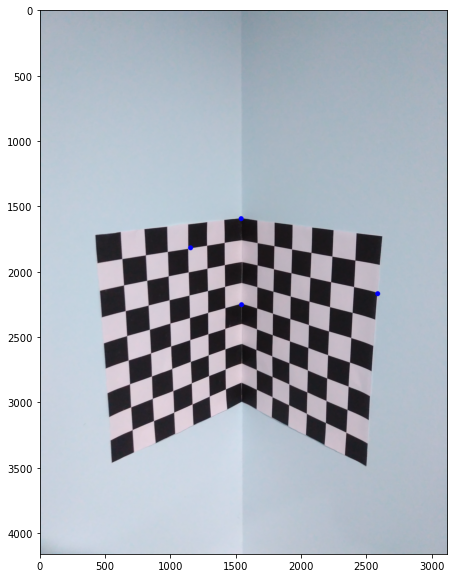

In [80]:
err,P,K,R,t = DLT(points_2d,points_3d,points_2d,points_3d)
world_points=np.array([[0,0,0],[0,112,0],[112,0,168],[196,56,0]])
print(world_points)
total_3dpoints = np.concatenate((world_points,np.ones((world_points.shape[0],1))),axis=1)
pred_2d = P.dot(total_3dpoints.T).T
print(pred_2d.shape)
for i in range(pred_2d.shape[0]):
    pred_2d[i,:] = pred_2d[i,:]/pred_2d[i,2]
pred_2d = pred_2d[:,:2]
im = cv2.imread('calibration-data/calib-object.jpg')
for point in pred_2d:
    print(point)
    cv2.circle(im,(int(point[0]),int(point[1])),6,(0,0,255),25)
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()

In [81]:
Cor = [[-1,0,0],[0,-1,0],[0,0,1]]
cor = np.array(Cor)
K = np.dot(K,cor)
R = np.dot(cor,R)
print("Corrected Camera Matrix :")
print(K)
print()
print("Corrected Rotation Matrix")
print(R)
print()
print("Projection Center")
print(t)

Corrected Camera Matrix :
[[-3.46697719e+03 -2.18718739e+01  1.67532539e+03]
 [ 0.00000000e+00 -3.52784287e+03  1.97580936e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Corrected Rotation Matrix
[[ 0.72311854 -0.01057097 -0.69064305]
 [ 0.16476478  0.97365897  0.15760956]
 [ 0.67078472 -0.22776405  0.70581258]]

Projection Center
[411.05077298 -70.67396734 399.19489929]


### Question 1:

2. The K-matrix that is corrected have the 1st 2 columns as negative and the R-matrix that is corrected  have the 1st 2 rows negative.For p formulization we will multiply K and R. So, when we do the same with corrected K and R we get same,i.e. $$K*R(Z,pi)R(Z,pi)*R=K*R$$  because   $$R(Z,pi)*R(Z,pi)$$ will be identity matrix.

## RANSAC DLT

In [82]:
def RANSAC(points_2d,points_3d):
    max_iter = 1000
    min_err = 1e+10
    for i in range(max_iter):
        a = np.arange(points_2d.shape[0])
        np.random.shuffle(a)
        rand = a[:6]
        try:
            err,P,K,R,t = DLT(points_2d[rand],points_3d[rand],points_2d,points_3d)
            if err < min_err:
                min_err,PP,KK,RR,tt = err,P,K,R,t
        except:
            pass
    print("Error" , min_err)
    print("Projection Matrix")
    print(PP)
    print()
    print("Camera Matrix")
    print(KK)
    print()
    print("Rotation Matrix")
    print(RR)
    print()
    print("Projection Center")
    print(tt)

In [8]:
RANSAC(points_2d,points_3d)

Error 32.52719892446339
Projection Matrix
[[ 1.07869002e-03  2.31483334e-04 -2.78449630e-03  6.93562585e-01]
 [-6.04465090e-04  2.98041928e-03 -5.88649716e-04  7.20383350e-01]
 [-5.41484922e-07  1.49642207e-07 -5.12550147e-07  4.51116064e-04]]

Camera Matrix
[[3.63423934e+03 2.16340553e+01 1.51777559e+03]
 [0.00000000e+00 3.62431316e+03 1.85890700e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Rotation Matrix
[[-0.68680948  0.00425879  0.72682502]
 [-0.14589311 -0.98043895 -0.1321161 ]
 [ 0.7120449  -0.19677735  0.67399609]]

Projection Center
[426.27015228 -74.66912139 408.00603225]


### Question 1:

3. Ransac :
    
    Consider 6 random points. Calculate the p matrix using DLT function and calculate the error. Update the error if present_error < error and update final p matrix as well. Here, P_best chages sometimes but the k-matrix remains same.

### 2)


In [2]:
Error = 1-0.8
sample = 6
prob = 0.95
T = np.log(1-prob)/np.log(1-(1-Error)**sample)
print("No of Iterations Required = ",math.ceil(T))

No of Iterations Required =  10


### Question 1:

3. Ransac :

    2. Number of trials needed = 
    $$\frac{\log(1-p)}{\log(1-(1-e)^s)}$$
    
  - Where, probability and 1-e is accuracy and number of points used to get error(sample points) i.e. sample = 6 
  - Approximately 10 trails are needed for 80% accuracy with 95% probability.  

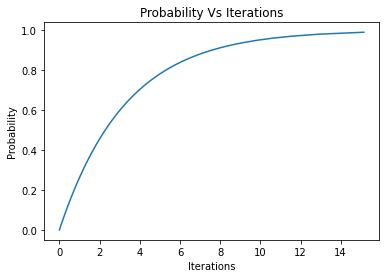

In [4]:
%matplotlib inline
prob = np.arange(0,1,0.01)
T = np.log(1-prob)/np.log(1-(1-Error)**sample)
plt.title("Probability Vs Iterations")
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.plot(T,prob)

# Zhangs Method 

In [9]:
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)
_3d_points=[]
_2d_points=[]
for i in range(56,71):
    im=cv2.imread('calibration-data/IMG_54' + str(i) + '.JPG')
    ret, corners = cv2.findChessboardCorners(im, (8,6))    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)

Reprojection Error: 2.4810849838638074
Camera Calibration Matrix:
[[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.52132296e-02  1.01092580e+01 -1.52797799e-02  2.87213434e-02
  -1.60589622e+02]]
Rotation Vectors for the images are:
[array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.00906861],
       [-0.41619662],
       [-0.03572076]]), array([[ 0.01633962],
       [-0.61839259],
       [-0.07755518]]), array([[0.00456626],
       [0.30778498],
       [0.06543949]]), array([[-0.32566614],
       [-0.22232074],
       [-0.01742858]]), array([[-0.19221712],
       [-0.38502427],
       [-0.00381479]]), array([[ 0.24427921],
       [-0.32262063],
       [ 0.02472159]]), array([[0.31114498],
       [0.0663294 ],
       [0.07053942]]), array([[ 0.34957373],
       [-0.563

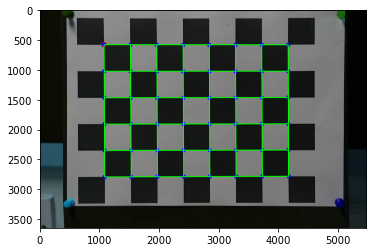

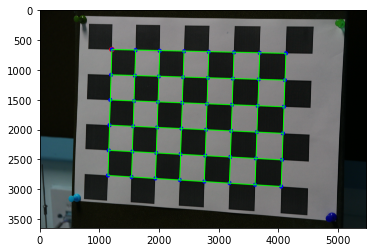

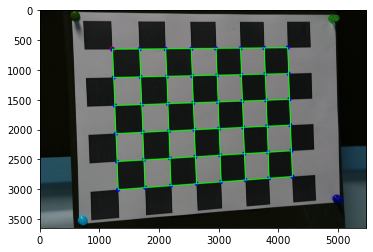

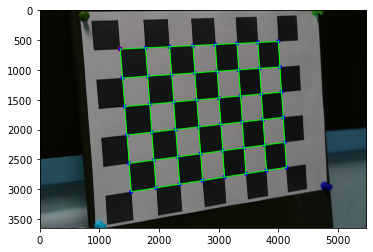

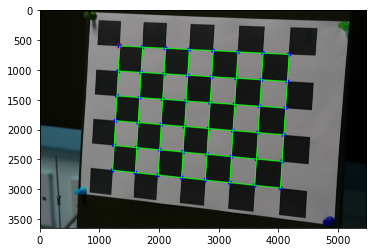

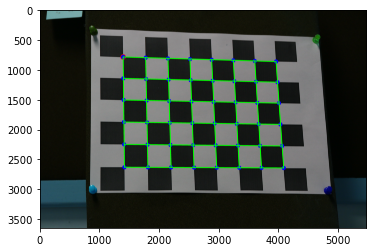

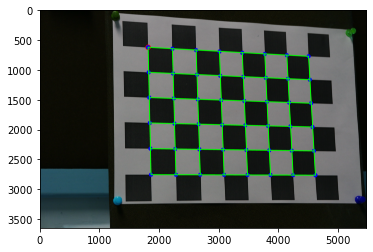

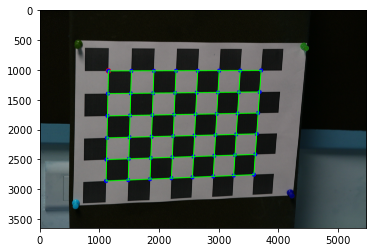

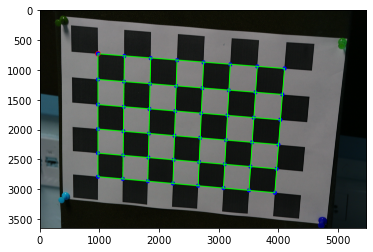

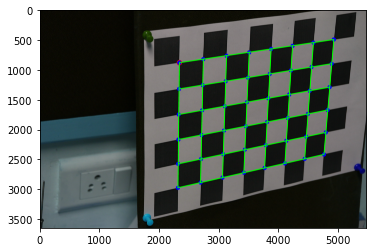

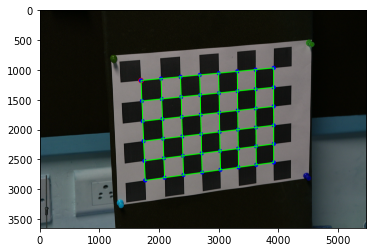

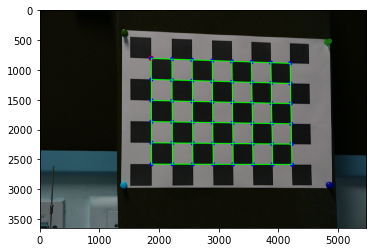

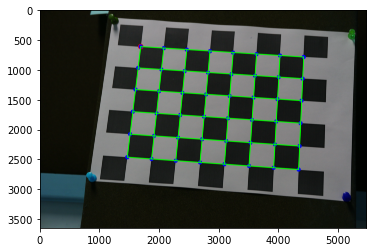

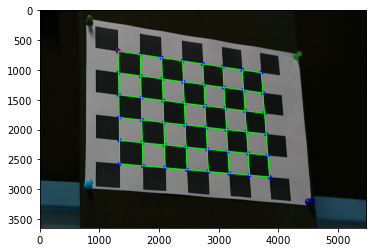

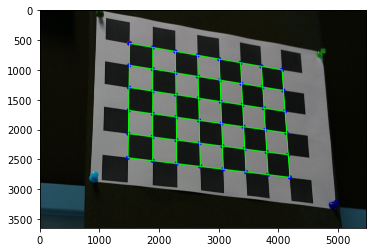

In [10]:
for i in range(len(_3d_points)):
    im=cv2.imread('calibration-data/IMG_54' + str(i+56) + '.JPG')
    pred2d, _ = cv2.projectPoints(_3d_points[i], rvecs[i], tvecs[i], mtx, dist)
    count = 0
    start = 0
    cv2.circle(im,(int(pred2d[0][0][0]),int(pred2d[0][0][1])),6,(255,0,0),80)
    for point in pred2d:
        if count % 8 == 0:
            start = point
        cv2.circle(im,(int(point[0][0]),int(point[0][1])),6,(0,0,255),60)
        count += 1
        if count % 8 == 0:
            cv2.line(im,(int(start[0][0]),int(start[0][1])),(int(point[0][0]),int(point[0][1])),(0,255,0), 15)
    count = 0
    for j in range(0,8):
        cv2.line(im,(int(pred2d[j][0][0]),int(pred2d[j][0][1])),(int(pred2d[j+40][0][0]),int(pred2d[j+40][0][1])),(0,255,0), 15)
    plt.imshow(im)
    plt.show()

### Question 2:

- The inbuilt cv2.calibrateCamera uses Zhang’s method itself.
- cv2.calibrateCamera function returns the following values:
  - ret: the mean reprojection error
  - mtx: the matrix of intrinsic parameters
  - dist: the distortion parameters
  - rvecs: the rotation vectors (one per image)
  - tvecs: the translation vectors (one per image)

- observation: The lines overlay on the sides of the checker board.

# DIY

In [58]:
# def mouse_drawing(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print("Left click")
#         points.append((x, y))

# # cap = cv2.VideoCapture(0)
# cv2.namedWindow("Frame", cv2.WINDOW_NORMAL)
# cv2.setMouseCallback("Frame", mouse_drawing)
# points = []
# frame = cv2.imread('DLT.jpg', cv2.IMREAD_COLOR)

# while True:
#     # _, frame = cap.read()
#     for center_position in points:
#         cv2.circle(frame, center_position, 15, (0, 0, 255), -1)
#     cv2.imshow("Frame", frame)
#     key = cv2.waitKey(1)
#     if key == ord('d'):
#         break
    
# # cap.release()
# cv2.destroyAllWindows()
# print(len(points))
# print(points)
# np.save("PPoints2.npy", np.array(points))

In [84]:
d = 20
points3d = np.zeros((13,3))
for i in range(0,5):
    points3d[i,0] = i*d
for i in range(1,5):
    points3d[4+i,1] = i*d
for i in range(1,5):
    points3d[8+i,2] = i*d
points3d
np.save("PPoints3.npy", np.array(points3d))

In [85]:
points_2d = np.load("PPoints2.npy")
points_3d = np.load("PPoints3.npy")
err,P,K,R,t = DLT(points_2d,points_3d,points_2d,points_3d)
print("Error" , err)
print("Projection Matrix")
print(P)
print()
print("Camera Matrix")
print(K)
print()
print("Rotation Matrix")
print(R)
print()
print("Projection Center")
print(t)

Error 1.183087833251015
Projection Matrix
[[-4.10436905e-03  2.55021007e-03  9.92065539e-04 -8.72876236e-01]
 [-3.41503804e-06 -5.46316203e-04  4.52738870e-03 -4.87893428e-01]
 [ 1.80120592e-07  3.88428320e-06  1.64962013e-06 -1.39666689e-03]]

Camera Matrix
[[ 9.98603782e+02 -6.73546583e+00  6.05502973e+02]
 [ 0.00000000e+00  1.03721412e+03  2.99630397e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Rotation Matrix
[[-0.9990045   0.04437159  0.00460073]
 [-0.01309826 -0.39035156  0.9205727 ]
 [ 0.04264318  0.91959601  0.39054415]]

Projection Center
[  7.34621374 298.17821103 143.75132039]


[[ 0  0  0]
 [ 0 80  0]
 [80  0 80]
 [40 40  0]]
(4, 3)
[624.97095059 349.32698024]
[615.93563102 489.53573955]
[897.28194162 100.75724299]
[757.67734391 413.16465696]


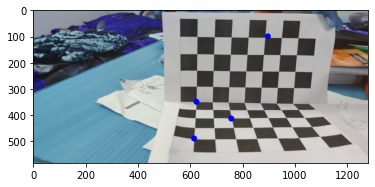

In [86]:
world_points=np.array([[0,0,0],[0,80,0],[80,0,80],[40,40,0]])
print(world_points)
total_3dpoints = np.concatenate((world_points,np.ones((world_points.shape[0],1))),axis=1)
pred_2d = P.dot(total_3dpoints.T).T
print(pred_2d.shape)
for i in range(pred_2d.shape[0]):
    pred_2d[i,:] = pred_2d[i,:]/pred_2d[i,2]
pred_2d = pred_2d[:,:2]
im = cv2.imread("DLT.jpg")
for point in pred_2d:
    print(point)
    cv2.circle(im,(int(point[0]),int(point[1])),6,(0,0,255),10)
plt.imshow(im)
plt.show()

In [88]:
RANSAC(points_2d,points_3d)

Error 1.9190575366167175
Projection Matrix
[[ 3.77376074e-03 -2.32056388e-03 -1.34394805e-03  8.73570303e-01]
 [-1.31783401e-04  7.43977937e-04 -4.57322616e-03  4.86651882e-01]
 [-5.63161131e-07 -3.53897168e-06 -2.21938116e-06  1.39772339e-03]]

Camera Matrix
[[9.72468499e+02 2.62619487e+00 5.10488226e+02]
 [0.00000000e+00 1.01327546e+03 4.27251510e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Rotation Matrix
[[-0.99070699  0.12681147  0.04917834]
 [-0.02548031 -0.5282077   0.84873281]
 [ 0.13360543  0.83959245  0.52653026]]

Projection Center
[  6.21106857 297.03699952 154.55661161]


### Question 3:

- Ran both the models and results are observed as above.
